In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

import imgaug as ia
import imgaug.augmenters as iaa

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES, FILE_DATASET
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces_eyes/dataset_dlib.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=IMAGE_SIZE)
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = dataset.images
mrks = dataset.mrks
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])
# y_eyes /= x.shape[1]

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(5731, 256, 256, 3) float32
(5731, 23) int32
(5731, 4) float64
5731


In [7]:
y_eyes

array([[122.5, 118.5, 160.5, 120.5],
       [114. , 117. , 150. , 124.5],
       [105. , 115. , 146.5, 114. ],
       ...,
       [104.5, 103.5, 152.5, 104.5],
       [106.5,  99.5, 153. , 102.5],
       [103.5,  90.5, 158. ,  92.5]])

#### divide train and test

In [8]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(5151, 256, 256, 3) (5151, 23) (5151, 4)
(580, 256, 256, 3) (580, 23) (580, 4)


In [9]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Data Augmentation 

In [10]:
class ImageLandmarkGenerator(Sequence):
    """ImageDataGenerator + ImgAug"""
    def __init__(self, x, y_reqs, y_eyes, batch_size=32, shuffle=True, **affine_kwargs):
        self.x = x
        self.y_reqs = y_reqs
        self.y_eyes = y_eyes
        self.batch_size = min(batch_size, x.shape[0])
        self.shuffle = shuffle
        self.aug = iaa.Affine(**affine_kwargs)
        self.indexes = np.arange(self.x.shape[0])
        if shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return self.x.shape[0] // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = self.x[indexes]
        reqs = self.y_reqs[indexes]
        landmarks = self.y_eyes[indexes]
        shape = self.x.shape[1:]
        
        keypoints = [ia.KeypointsOnImage.from_xy_array(landmark.reshape(-1, 2), shape=shape) for landmark in landmarks]
        images_aug, keypoints_aug = self.aug(images=images, keypoints=keypoints)
        landmarks_aug = np.array([kp.to_xy_array().flatten() for kp in keypoints_aug])

        return images_aug / 255, [images_aug / 255, reqs, landmarks_aug / x.shape[1]]

(3, 256, 256, 3) (3, 4)


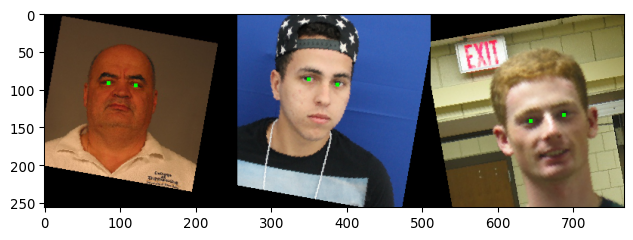

In [11]:
affine_params = dict(
    translate_percent=[-0.1, 0.1],
    rotate=[-10, 10],
    scale=[0.9, 1.1],
    order=0,
)

gen = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=3, **affine_params)
_, (images, _, landmarks) = gen.__getitem__(0)
print(images.shape, landmarks.shape)

draw_list = []
for im, landmark in zip(images, landmarks):
    kp = ia.KeypointsOnImage.from_xy_array((landmark * x_train.shape[1]).reshape(-1, 2), shape=im.shape)
    draw_list.append(kp.draw_on_image((im * 255).astype(np.uint8)[:, :, ::-1], size=5))

ia.imshow(np.hstack(draw_list))

# Model Training 

In [12]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate)(prev_input)
    out = Dense(units, activation=activation)(prev_input)
    return out

In [13]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_REQS = y_train_reqs.shape[1]
N_EYES = y_train_eyes.shape[1]

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 16)
pool_2 = conv_bn_maxpool(2, pool_1, 32)
pool_3 = conv_bn_maxpool(3, pool_2, 64)
pool_4 = conv_bn_maxpool(4, pool_3, 128)
pool_5 = conv_bn_maxpool(5, pool_4, 256)
encode = conv_bn(6, pool_5, 256, activation='tanh', name='encoded')

dec_5 = deconv_bn(5, encode, 256)
dec_4 = deconv_bn(4, dec_5, 128)
dec_3 = deconv_bn(3, dec_4, 64)
dec_2 = deconv_bn(2, dec_3, 32)
dec_1 = deconv_bn(1, dec_2, 16)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

avg_pool = GlobalAvgPool2D()(encode)
dense_1 = dense_layer(1, avg_pool, 64)
dense_2 = dense_layer(2, dense_1, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='output_reqs')(dense_2)

dense_3 = dense_layer(3, avg_pool, 64)
dense_4 = dense_layer(4, dense_3, 32)
regress = Dense(units=N_EYES, activation='sigmoid', name='output_eyes')(dense_4)

model = Model(inputs=inputs, outputs=[decoded, classif, regress])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 256, 256, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 256, 256, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

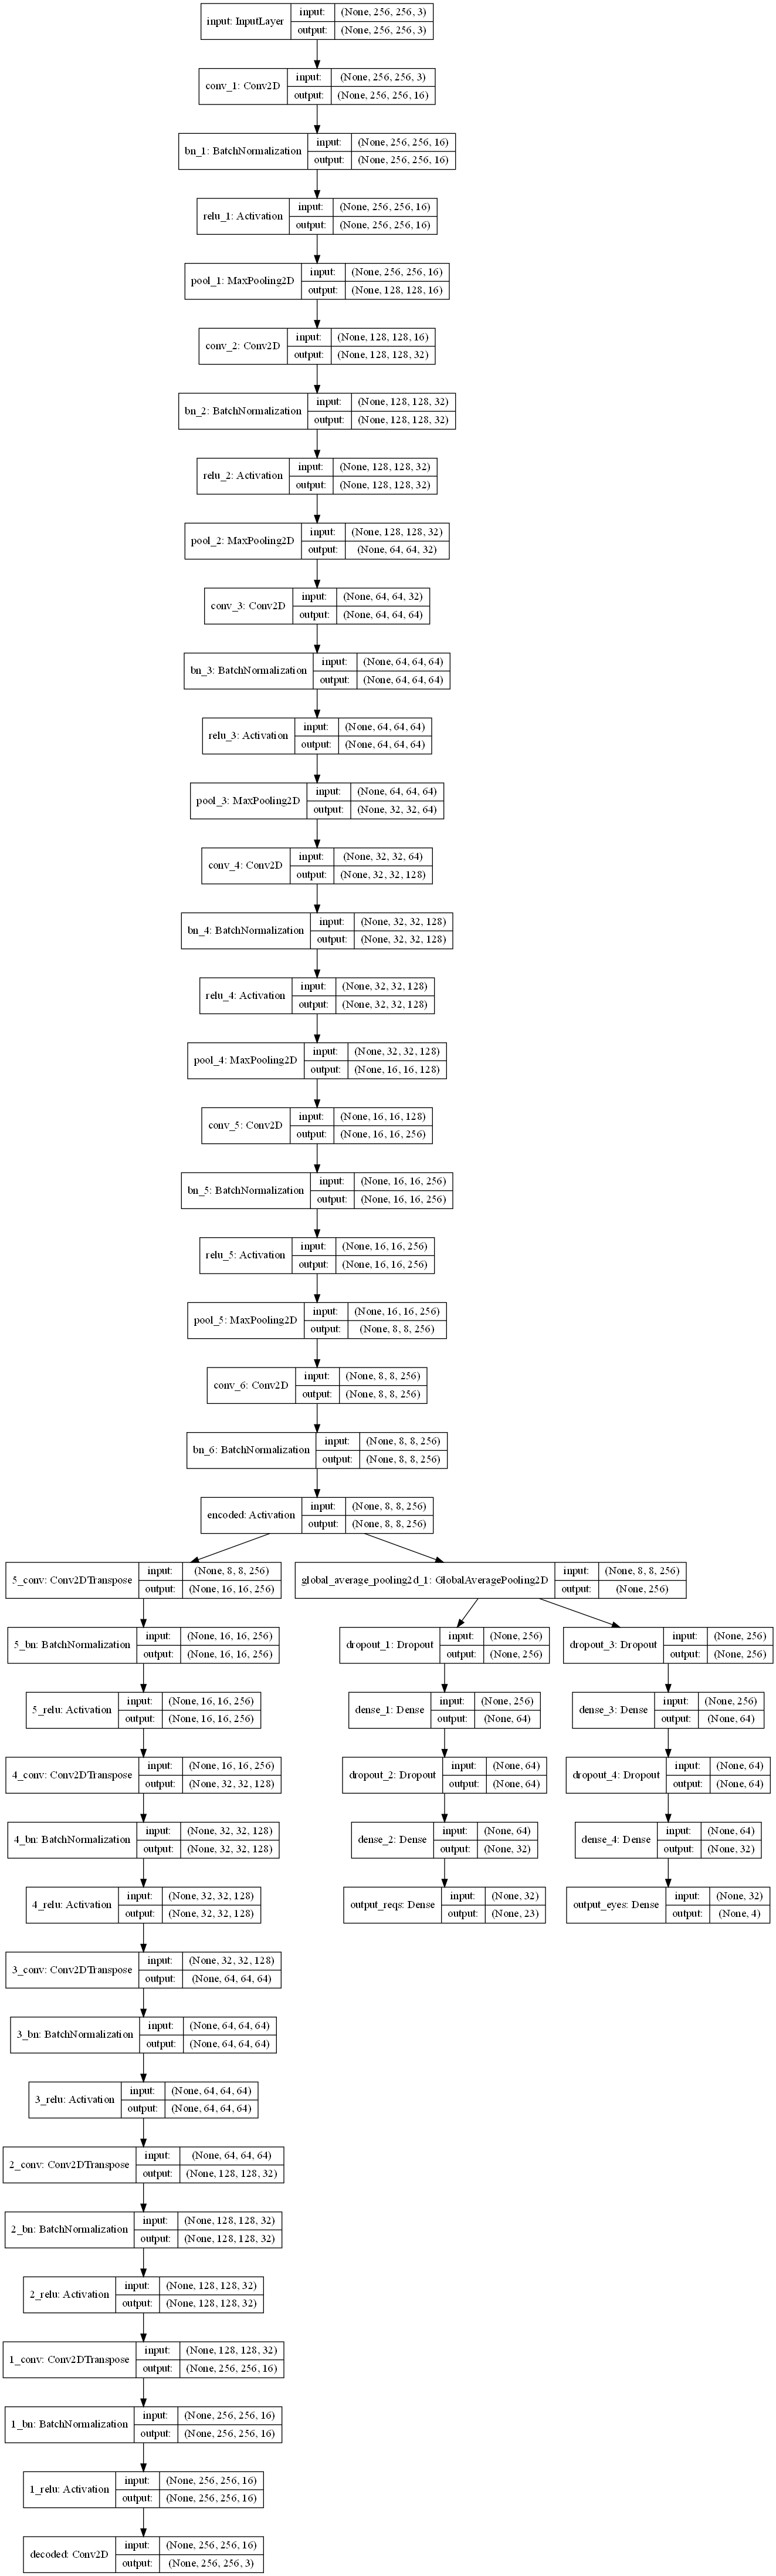

In [14]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 51s 509ms/step - loss: 116.9043 - decoded_loss: 0.0519 - output_reqs_loss: 0.5872 - output_eyes_loss: 29.0533 - output_reqs_accuracy: 0.6900 - output_reqs_precision: 0.8209 - output_reqs_recall: 0.7811 - output_reqs_f1: 0.7912 - output_reqs_fbeta: 0.7807 - output_reqs_specificity: 0.3341 - output_reqs_negative_predictive_value: 0.3323 - output_reqs_matthews_correlation_coefficient: 0.1293 - output_eyes_mae: 0.0801 - output_eyes_mse: 0.0134 - val_loss: 192.3606 - val_decoded_loss: 0.1430 - val_output_reqs_loss: 0.5144 - val_output_eyes_loss: 40.6401 - val_output_reqs_accuracy: 0.7928 - val_output_reqs_precision: 0.8037 - val_output_reqs_recall: 0.9753 - val_output_reqs_f1: 0.8811 - val_output_reqs_fbeta: 0.9323 - val_output_reqs_specificity: 0.1138 - val_output_reqs_negative_predictive_value: 0.5521 - val_output_reqs_matthews_correlation_coefficient: 0.1780 - val_output_eyes_mae: 0.107

100/100 [==============================] - 44s 444ms/step - loss: 79.2967 - decoded_loss: 0.0267 - output_reqs_loss: 0.4263 - output_eyes_loss: 19.7043 - output_reqs_accuracy: 0.8036 - output_reqs_precision: 0.8148 - output_reqs_recall: 0.9756 - output_reqs_f1: 0.8878 - output_reqs_fbeta: 0.9354 - output_reqs_specificity: 0.1254 - output_reqs_negative_predictive_value: 0.5647 - output_reqs_matthews_correlation_coefficient: 0.1953 - output_eyes_mae: 0.0375 - output_eyes_mse: 0.0061 - val_loss: 77.3331 - val_decoded_loss: 0.0654 - val_output_reqs_loss: 0.4706 - val_output_eyes_loss: 29.5024 - val_output_reqs_accuracy: 0.7923 - val_output_reqs_precision: 0.8033 - val_output_reqs_recall: 0.9751 - val_output_reqs_f1: 0.8808 - val_output_reqs_fbeta: 0.9320 - val_output_reqs_specificity: 0.1128 - val_output_reqs_negative_predictive_value: 0.5486 - val_output_reqs_matthews_correlation_coefficient: 0.1758 - val_output_eyes_mae: 0.0489 - val_output_eyes_mse: 0.0108

Epoch 00008: val_output_reqs_


Epoch 00015: val_output_reqs_fbeta improved from 0.93270 to 0.94006, saving model to ../../models/unsupervised_supervised/multilearner_2022_05_29-11_30_57.h5
Epoch 16/100
100/100 [==============================] - 44s 443ms/step - loss: 69.6672 - decoded_loss: 0.0211 - output_reqs_loss: 0.4117 - output_eyes_loss: 17.3033 - output_reqs_accuracy: 0.8054 - output_reqs_precision: 0.8230 - output_reqs_recall: 0.9637 - output_reqs_f1: 0.8877 - output_reqs_fbeta: 0.9283 - output_reqs_specificity: 0.1766 - output_reqs_negative_predictive_value: 0.5505 - output_reqs_matthews_correlation_coefficient: 0.2283 - output_eyes_mae: 0.0291 - output_eyes_mse: 0.0055 - val_loss: 176.5398 - val_decoded_loss: 0.0379 - val_output_reqs_loss: 0.4745 - val_output_eyes_loss: 25.5706 - val_output_reqs_accuracy: 0.7973 - val_output_reqs_precision: 0.8041 - val_output_reqs_recall: 0.9823 - val_output_reqs_f1: 0.8842 - val_output_reqs_fbeta: 0.9373 - val_output_reqs_specificity: 0.1085 - val_output_reqs_negative_p


Epoch 00023: val_output_reqs_fbeta did not improve from 0.94309
Epoch 24/100
100/100 [==============================] - 44s 443ms/step - loss: 60.4570 - decoded_loss: 0.0211 - output_reqs_loss: 0.4091 - output_eyes_loss: 15.0014 - output_reqs_accuracy: 0.8052 - output_reqs_precision: 0.8238 - output_reqs_recall: 0.9615 - output_reqs_f1: 0.8872 - output_reqs_fbeta: 0.9270 - output_reqs_specificity: 0.1887 - output_reqs_negative_predictive_value: 0.5546 - output_reqs_matthews_correlation_coefficient: 0.2378 - output_eyes_mae: 0.0254 - output_eyes_mse: 0.0044 - val_loss: 133.6341 - val_decoded_loss: 0.0293 - val_output_reqs_loss: 0.4592 - val_output_eyes_loss: 27.0201 - val_output_reqs_accuracy: 0.8011 - val_output_reqs_precision: 0.8119 - val_output_reqs_recall: 0.9732 - val_output_reqs_f1: 0.8852 - val_output_reqs_fbeta: 0.9329 - val_output_reqs_specificity: 0.1587 - val_output_reqs_negative_predictive_value: 0.6068 - val_output_reqs_matthews_correlation_coefficient: 0.2348 - val_outpu


Epoch 00031: val_output_reqs_fbeta did not improve from 0.94327
Epoch 32/100
100/100 [==============================] - 44s 443ms/step - loss: 66.8128 - decoded_loss: 0.0274 - output_reqs_loss: 0.4148 - output_eyes_loss: 16.5858 - output_reqs_accuracy: 0.8044 - output_reqs_precision: 0.8183 - output_reqs_recall: 0.9703 - output_reqs_f1: 0.8877 - output_reqs_fbeta: 0.9322 - output_reqs_specificity: 0.1506 - output_reqs_negative_predictive_value: 0.5638 - output_reqs_matthews_correlation_coefficient: 0.2142 - output_eyes_mae: 0.0278 - output_eyes_mse: 0.0050 - val_loss: 30.8173 - val_decoded_loss: 0.0377 - val_output_reqs_loss: 0.4436 - val_output_eyes_loss: 26.4378 - val_output_reqs_accuracy: 0.8056 - val_output_reqs_precision: 0.8304 - val_output_reqs_recall: 0.9469 - val_output_reqs_f1: 0.8847 - val_output_reqs_fbeta: 0.9185 - val_output_reqs_specificity: 0.2794 - val_output_reqs_negative_predictive_value: 0.5849 - val_output_reqs_matthews_correlation_coefficient: 0.3063 - val_output


Epoch 00039: val_output_reqs_fbeta did not improve from 0.94327
Epoch 40/100
100/100 [==============================] - 44s 443ms/step - loss: 73.3826 - decoded_loss: 0.0276 - output_reqs_loss: 0.4130 - output_eyes_loss: 18.2286 - output_reqs_accuracy: 0.8014 - output_reqs_precision: 0.8230 - output_reqs_recall: 0.9566 - output_reqs_f1: 0.8846 - output_reqs_fbeta: 0.9229 - output_reqs_specificity: 0.1927 - output_reqs_negative_predictive_value: 0.5296 - output_reqs_matthews_correlation_coefficient: 0.2290 - output_eyes_mae: 0.0320 - output_eyes_mse: 0.0063 - val_loss: 121.7423 - val_decoded_loss: 0.1903 - val_output_reqs_loss: 0.4568 - val_output_eyes_loss: 33.4033 - val_output_reqs_accuracy: 0.7934 - val_output_reqs_precision: 0.8037 - val_output_reqs_recall: 0.9766 - val_output_reqs_f1: 0.8816 - val_output_reqs_fbeta: 0.9331 - val_output_reqs_specificity: 0.1111 - val_output_reqs_negative_predictive_value: 0.5589 - val_output_reqs_matthews_correlation_coefficient: 0.1780 - val_outpu


Epoch 00047: val_output_reqs_fbeta did not improve from 0.94327
Epoch 48/100
100/100 [==============================] - 44s 444ms/step - loss: 63.2417 - decoded_loss: 0.0221 - output_reqs_loss: 0.3995 - output_eyes_loss: 15.6995 - output_reqs_accuracy: 0.8094 - output_reqs_precision: 0.8310 - output_reqs_recall: 0.9564 - output_reqs_f1: 0.8891 - output_reqs_fbeta: 0.9247 - output_reqs_specificity: 0.2224 - output_reqs_negative_predictive_value: 0.5591 - output_reqs_matthews_correlation_coefficient: 0.2635 - output_eyes_mae: 0.0311 - output_eyes_mse: 0.0061 - val_loss: 85.2560 - val_decoded_loss: 0.1002 - val_output_reqs_loss: 0.4651 - val_output_eyes_loss: 29.8315 - val_output_reqs_accuracy: 0.8019 - val_output_reqs_precision: 0.8213 - val_output_reqs_recall: 0.9566 - val_output_reqs_f1: 0.8837 - val_output_reqs_fbeta: 0.9237 - val_output_reqs_specificity: 0.2289 - val_output_reqs_negative_predictive_value: 0.5872 - val_output_reqs_matthews_correlation_coefficient: 0.2751 - val_output


Epoch 00055: val_output_reqs_fbeta did not improve from 0.94327
Epoch 56/100
100/100 [==============================] - 44s 443ms/step - loss: 57.9000 - decoded_loss: 0.0214 - output_reqs_loss: 0.4037 - output_eyes_loss: 14.3634 - output_reqs_accuracy: 0.8084 - output_reqs_precision: 0.8295 - output_reqs_recall: 0.9566 - output_reqs_f1: 0.8884 - output_reqs_fbeta: 0.9247 - output_reqs_specificity: 0.2222 - output_reqs_negative_predictive_value: 0.5627 - output_reqs_matthews_correlation_coefficient: 0.2644 - output_eyes_mae: 0.0305 - output_eyes_mse: 0.0060 - val_loss: 16.9932 - val_decoded_loss: 0.0377 - val_output_reqs_loss: 0.4515 - val_output_eyes_loss: 26.2297 - val_output_reqs_accuracy: 0.8024 - val_output_reqs_precision: 0.8094 - val_output_reqs_recall: 0.9804 - val_output_reqs_f1: 0.8866 - val_output_reqs_fbeta: 0.9373 - val_output_reqs_specificity: 0.1392 - val_output_reqs_negative_predictive_value: 0.6514 - val_output_reqs_matthews_correlation_coefficient: 0.2342 - val_output

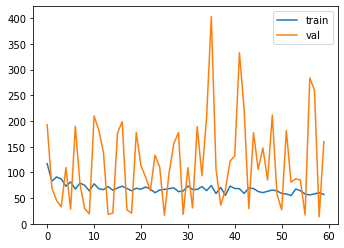

In [15]:
DECODED_LOSS_WEIGHT = 2.0
REQS_LOSS_WEIGHT = 1.0
EYES_LOSS_WEIGHT = 4.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "output_reqs": "binary_crossentropy",
    "output_eyes": "mean_absolute_percentage_error"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "output_reqs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "output_reqs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae", "mse"]
}
METRIC_TO_MONITOR = "val_output_reqs_fbeta"

outputs_train = {
    "decoded": x_train,
    "output_reqs": y_train_reqs,
    "output_eyes": y_train_eyes,
}

outputs_valid = {
    "decoded": x_val,
    "output_reqs": y_val_reqs,
    "output_eyes": y_val_eyes,
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

affine_params = dict(
    translate_percent=[-0.1, 0.1],
    rotate=[-10, 10],
    scale=[0.9, 1.1],
    order=0,
)

gen_train = ImageLandmarkGenerator(x_train, y_train_reqs, y_train_eyes, batch_size=32, **affine_params)
gen_valid = ImageLandmarkGenerator(x_val, y_val_reqs, y_val_eyes, batch_size=32, **affine_params)

hist = model.fit_generator(
    gen_train,
    steps_per_epoch=100,
    epochs=100,
    validation_data=gen_valid,
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

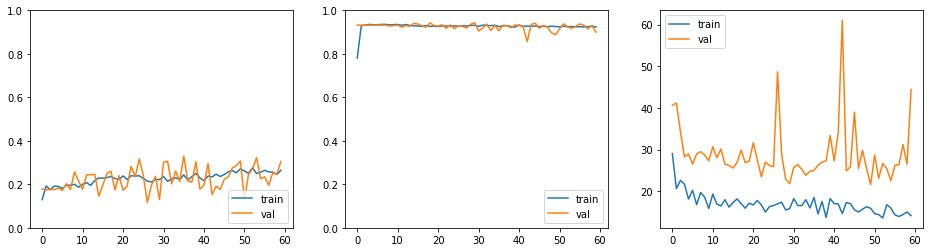

In [16]:
history = hist.history


plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(history['output_reqs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_output_reqs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history['output_reqs_fbeta'], label='train')
plt.plot(history['val_output_reqs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 3, 3)
plt.plot(history['output_eyes_loss'], label='train')
plt.plot(history['val_output_eyes_loss'], label='val')
plt.legend(loc='upper left')

# Test Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1]
[109.5 115.5 145.  114. ]
[0.27919477 0.29589605 0.41498354 0.27994758]


Text(0.5, 1.0, 'decoded image')

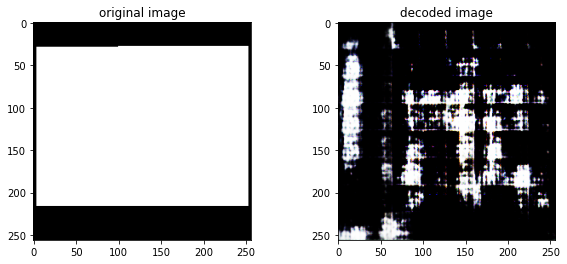

In [17]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx]

y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)

print(y_true_reqs, y_pred_reqs[0], sep='\n')
print(y_true_eyes, y_pred_eyes[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [18]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('output_reqs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2022_05_29-11_30_57.h5
Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 256, 256, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 256, 256, 16) 0           bn_1[0][0]                       
__________________________

In [19]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

../../data/cropped_faces/images/afwDB_0.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Reqs:
0.7824675
0.6580092
0.9913722
0.41810873
0.84641606
0.97419727
0.9358851
0.6560832
0.7313402
0.5490715
0.66115564
0.54706824
0.74664825
0.6168667
0.7618058
0.883737
0.81334734
0.9901995
0.65926224
0.7720883
0.9558032
0.7789764
0.97330725

Eyes:
0.31989488
0.34450066
0.46939865
0.34711525


# Embeddings Visualization 

In [20]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [21]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = dataset.images[x_val_idx]
mrks = dataset.mrks[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

580
(580, 256, 256, 3)


In [22]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [23]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [24]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

(6400, 6400, 3)


### Embeddings 

In [25]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 256, 256, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 256, 256, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 128, 128, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 128, 32)      4640      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 128, 128, 32)      128 

In [26]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

(580, 256)


### Tensorboard 

In [27]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [28]:
mlflow.end_run()